In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the two CSV files
df1 = pd.read_csv('./Data/Prof_Office_Data/office_group_records_07_02.csv')
df2 = pd.read_csv('./Data/Prof_Office_Data/office_actuator_records.csv')

#original_df = df1.copy() #Keep a copy to compare
## Toggle the values of Light Sensor.
df1.loc[df1['sensor_name'] == 'Light Sensor', 'state'] = 1 - df1['state']

# # Find rows where 'state' has changed
# changed_rows = df1[df1['state'] != original_df['state']]

# # Display only the changed rows
# print(changed_rows)

#remove the motion sensor data
# filtered_df1 = df1[df1['sensor_name'] != 'Motion Sensor']
# print(filtered_df1)


# Combine the two DataFrames (concatenating rows)
combined_office_data = pd.concat([df1, df2], ignore_index=True)

# Convert the 'datetime' column to a datetime data type if necessary
combined_office_data['datetime'] = pd.to_datetime(combined_office_data['seconds'], unit='s')
# combined_office_data['datetime'] = pd.to_datetime(combined_office_data['date'] + ' ' + combined_office_data['time'], format='%d/%m/%y %H:%M')

# Sort by the 'datetime' column
combined_office_data = combined_office_data.sort_values(by='datetime')

# Display the sorted, combined DataFrame
print(combined_office_data.head)


<bound method NDFrame.head of              date   time       seconds  state    sensor_name    thing_name  \
0      2024-07-02  00:02  1.719897e+09    1.0  Motion Sensor  OfficeMainPi   
1      2024-07-02  00:02  1.719897e+09    0.0  Motion Sensor  OfficeMainPi   
2      2024-07-02  00:03  1.719897e+09    1.0  Motion Sensor  OfficeMainPi   
3      2024-07-02  00:03  1.719897e+09    0.0  Motion Sensor  OfficeMainPi   
4      2024-07-02  00:04  1.719897e+09    1.0  Motion Sensor  OfficeMainPi   
...           ...    ...           ...    ...            ...           ...   
35364  2024-10-01  14:43  1.727812e+09    1.0   Light Sensor  OfficeMainPi   
35365  2024-10-01  14:43  1.727812e+09    1.0  Motion Sensor  OfficeMainPi   
35366  2024-10-01  14:43  1.727812e+09    0.0  Motion Sensor  OfficeMainPi   
35367  2024-10-01  14:43  1.727812e+09    0.0    Door Sensor  OfficeMainPi   
35844    10/01/24  14:43  1.727812e+09    0.0    Office Bulb      PiClient   

             thing_ip            

In [7]:
## total active sensors and actuators for a time window

#Only consider the data from august 20 to october 10
start_date = pd.to_datetime('2024-08-20')
end_date = pd.to_datetime('2024-10-10')
filtered_office_data = combined_office_data[(combined_office_data['datetime'] >= start_date) & (combined_office_data['datetime'] <= end_date)]
print(filtered_office_data.head)


combined_office_data = combined_office_data.set_index('datetime') #make the date column as index

filtered_office_data = filtered_office_data.set_index('datetime')


# combined_office_data_filtered = combined_office_data.between_time('07:00', '19:00')
# print(combined_office_data.size, combined_office_data_filtered.size)
office_hourly = combined_office_data.state.resample('6h').sum() #resample on hourly basis and get summary of sensor values on that hour.
# print(office_hourly.head(10))

filtered_office_hourly = filtered_office_data.state.resample('6h').sum()

#only take the resampled data from 7am to 7pm
# office_hourly = office_hourly.between_time('06:00', '18:00')
office_hourly = office_hourly.reset_index()

filtered_office_hourly = filtered_office_hourly.reset_index()

print(office_hourly.head(10))
# office_hourly.to_csv('test.csv', index=False)

<bound method NDFrame.head of              date   time       seconds  state    sensor_name    thing_name  \
23769  2024-08-20  08:58  1.724162e+09    1.0    Door Sensor  OfficeMainPi   
23770  2024-08-20  08:58  1.724162e+09    1.0  Motion Sensor  OfficeMainPi   
23771  2024-08-20  08:58  1.724162e+09    0.0  Motion Sensor  OfficeMainPi   
23772  2024-08-20  08:58  1.724162e+09    1.0  Motion Sensor  OfficeMainPi   
23773  2024-08-20  08:58  1.724162e+09    0.0  Motion Sensor  OfficeMainPi   
...           ...    ...           ...    ...            ...           ...   
35364  2024-10-01  14:43  1.727812e+09    1.0   Light Sensor  OfficeMainPi   
35365  2024-10-01  14:43  1.727812e+09    1.0  Motion Sensor  OfficeMainPi   
35366  2024-10-01  14:43  1.727812e+09    0.0  Motion Sensor  OfficeMainPi   
35367  2024-10-01  14:43  1.727812e+09    0.0    Door Sensor  OfficeMainPi   
35844    10/01/24  14:43  1.727812e+09    0.0    Office Bulb      PiClient   

             thing_ip            

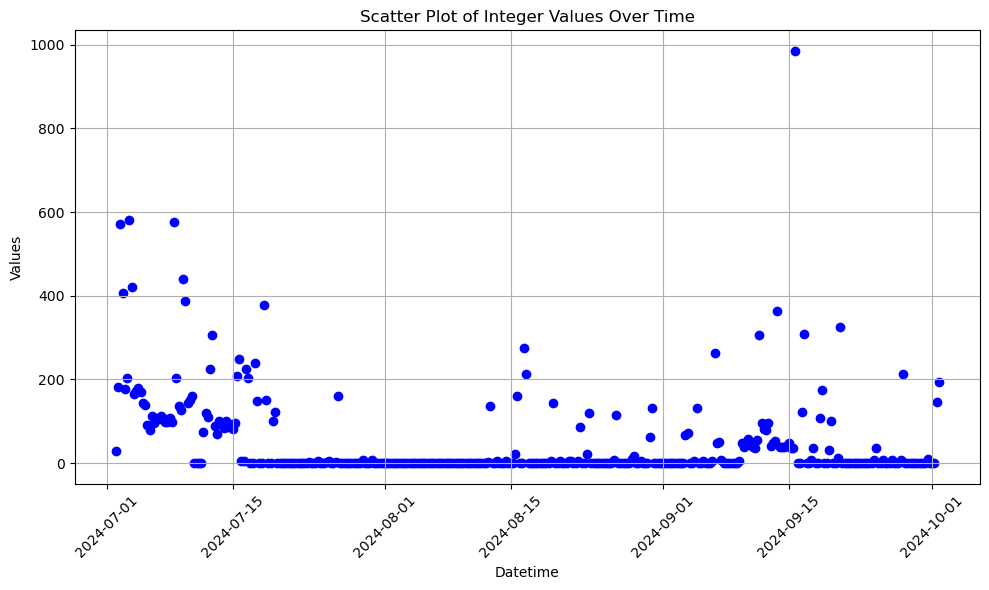

In [61]:
plt.figure(figsize=(10, 6))
plt.scatter(office_hourly['datetime'], office_hourly['state'], color='blue', marker='o')

# Formatting the plot
plt.title('Scatter Plot of Integer Values Over Time')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.grid(True)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

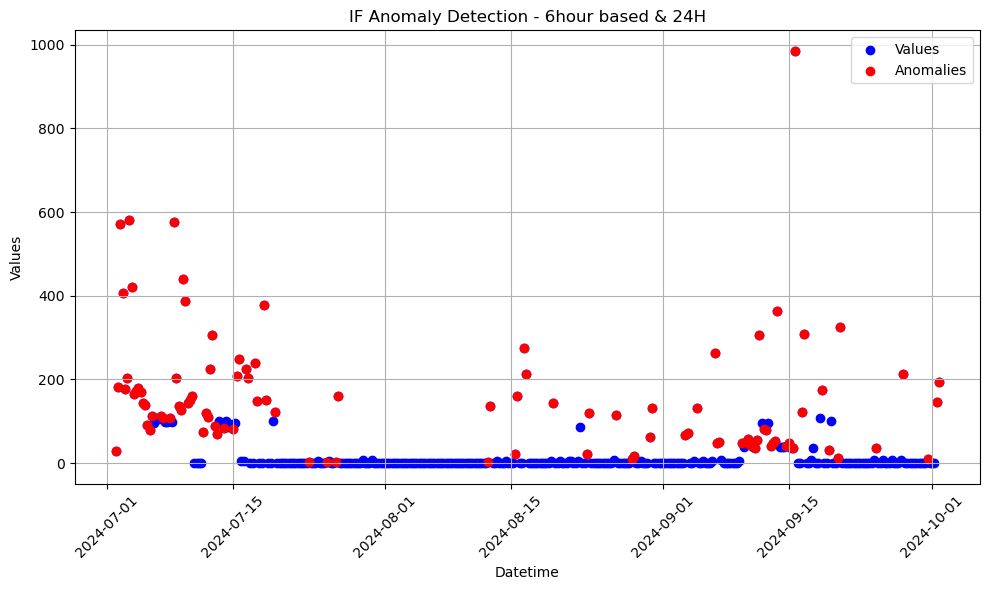

Total anomalies: 99, Percentage of anomalous values: 26.902173913043477%
               datetime  state  anomaly
17  2024-07-06 06:00:00   96.0        1
18  2024-07-06 12:00:00  109.0        1
19  2024-07-06 18:00:00  105.0        1
22  2024-07-07 12:00:00   98.0        1
23  2024-07-07 18:00:00   99.0        1
25  2024-07-08 06:00:00   98.0        1
46  2024-07-13 12:00:00  100.0        1
47  2024-07-13 18:00:00   94.0        1
49  2024-07-14 06:00:00  101.0        1
50  2024-07-14 12:00:00   87.0        1
51  2024-07-14 18:00:00   93.0        1
53  2024-07-15 06:00:00   97.0        1
56  2024-07-16 00:00:00    4.0        1
57  2024-07-16 06:00:00    6.0        1
70  2024-07-19 12:00:00  101.0        1
90  2024-07-24 12:00:00    4.0        1
95  2024-07-25 18:00:00    5.0        1
100 2024-07-27 00:00:00    1.0        1
110 2024-07-29 12:00:00    8.0        1
113 2024-07-30 06:00:00    1.0        1
114 2024-07-30 12:00:00    7.0        1
170 2024-08-13 12:00:00    6.0        1
174 202

In [62]:
from sklearn.ensemble import IsolationForest

# office_hourly['datetime'] = pd.to_datetime(office_hourly['datetime'])

# Prepare data for IsolationForest
values = office_hourly[['state']]  # Selecting the 'values' column as input for the model

# Initialize and fit the IsolationForest model
model = IsolationForest(contamination='auto', random_state=42)
office_hourly['anomaly'] = model.fit_predict(values)

# Isolation Forest outputs:
# -1 for anomalies
#  1 for normal data points

# Filter the anomalies
anomalies = office_hourly[office_hourly['anomaly'] == -1]
non_anomalies = office_hourly[office_hourly['anomaly'] == 1]
# print(df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(office_hourly['datetime'], office_hourly['state'], label='Values', color='blue', marker='o')
plt.scatter(anomalies['datetime'], anomalies['state'], color='red', label='Anomalies', marker='o')
plt.title('IF Anomaly Detection - 6hour based & 24H')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig('./Plots/Office_plots/IF_6H.png')
plt.show()


count_anomaly_h = (office_hourly['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_h = (count_anomaly_h / len(office_hourly)) * 100
print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

#only print the non anomalous values which are not zero
df_filtered = non_anomalies[non_anomalies['state'] != 0]
print(df_filtered)

print( non_anomalies)

non_anomalies.to_csv('./Output_CSV/regular_office.csv', index=False)
anomalies.to_csv('./Output_CSV/anomaly_office.csv', index=False)
# office_hourly.to_csv('./Output_CSV/IF_anomaly_2.csv', index=False)

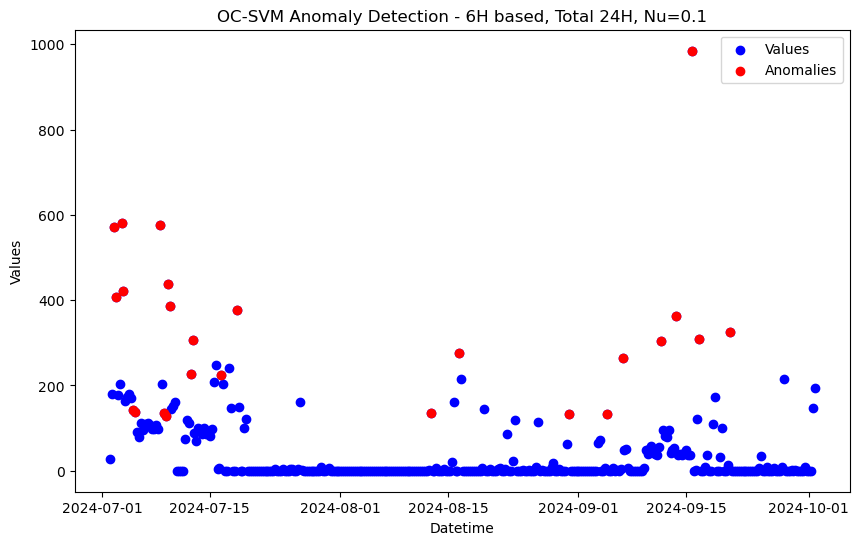

Total anomalies: 25, Percentage of anomalous values: 6.7934782608695645%
               datetime  state  anomaly  scaled_states
0   2024-07-02 00:00:00   28.0        1      -0.196659
1   2024-07-02 06:00:00  181.0        1       1.256829
4   2024-07-03 00:00:00  178.0        1       1.228329
5   2024-07-03 06:00:00  204.0        1       1.475327
8   2024-07-04 00:00:00  164.0        1       1.095330
..                  ...    ...      ...            ...
355 2024-09-28 18:00:00    1.0        1      -0.453156
357 2024-09-29 06:00:00    1.0        1      -0.453156
362 2024-09-30 12:00:00    9.0        1      -0.377157
366 2024-10-01 12:00:00  146.0        1       0.924332
367 2024-10-01 18:00:00  194.0        1       1.380328

[133 rows x 4 columns]
               datetime  state  anomaly  scaled_states
0   2024-07-02 00:00:00   28.0        1      -0.196659
1   2024-07-02 06:00:00  181.0        1       1.256829
4   2024-07-03 00:00:00  178.0        1       1.228329
5   2024-07-03 06:00:00

In [63]:
# using ocsvm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

scaler = StandardScaler()  # OC-SVM benefits from scaling the data
office_hourly['scaled_states'] = scaler.fit_transform(office_hourly[['state']])

# Train OC-SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)  # nu=0.05 means 5% anomalies expected
office_hourly['anomaly'] = ocsvm.fit_predict(office_hourly[['scaled_states']])

# In OC-SVM, -1 indicates an anomaly, and 1 indicates normal data
anomalies = office_hourly[office_hourly['anomaly'] == -1]
non_anomalies = office_hourly[office_hourly['anomaly'] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(office_hourly['datetime'], office_hourly['state'], label='Values', color='blue')
plt.scatter(anomalies['datetime'], anomalies['state'], color='red', label='Anomalies', marker='o')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.title('OC-SVM Anomaly Detection - 6H based, Total 24H, Nu=0.1')
plt.legend()
# plt.savefig('./Plots/Office_plots/SVM_6H_1.png')
plt.show()

count_anomaly_h = (office_hourly['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_h = (count_anomaly_h / len(office_hourly)) * 100
print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

#only print the non anomalous values which are not zero
df_filtered = non_anomalies[non_anomalies['state'] != 0]
print(df_filtered)

print( non_anomalies)

non_anomalies.to_csv('./Output_CSV/regular_office_svm.csv', index=False)
anomalies.to_csv('./Output_CSV/anomaly_office_svm.csv', index=False)

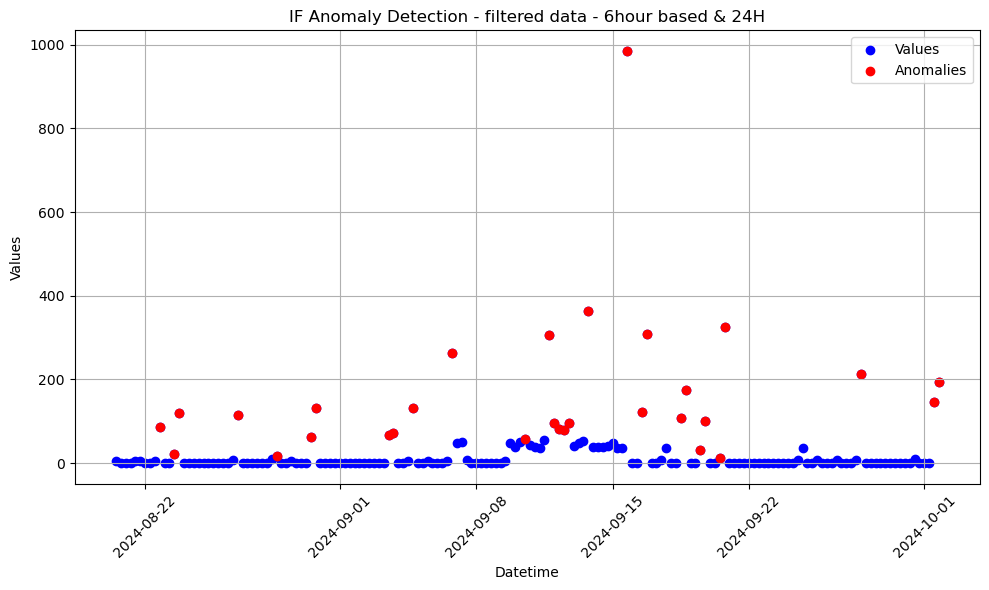

Total anomalies: 30, Percentage of anomalous values: 17.647058823529413%
               datetime  state  anomaly
0   2024-08-20 12:00:00    5.0        1
4   2024-08-21 12:00:00    4.0        1
5   2024-08-21 18:00:00    6.0        1
8   2024-08-22 12:00:00    4.0        1
17  2024-08-24 18:00:00    1.0        1
20  2024-08-25 12:00:00    1.0        1
24  2024-08-26 12:00:00    8.0        1
27  2024-08-27 06:00:00    1.0        1
32  2024-08-28 12:00:00    9.0        1
36  2024-08-29 12:00:00    4.0        1
60  2024-09-04 12:00:00    6.0        1
64  2024-09-05 12:00:00    6.0        1
66  2024-09-06 00:00:00    1.0        1
68  2024-09-06 12:00:00    4.0        1
70  2024-09-07 00:00:00   48.0        1
71  2024-09-07 06:00:00   51.0        1
72  2024-09-07 12:00:00    7.0        1
80  2024-09-09 12:00:00    6.0        1
81  2024-09-09 18:00:00   48.0        1
82  2024-09-10 00:00:00   39.0        1
83  2024-09-10 06:00:00   51.0        1
85  2024-09-10 18:00:00   44.0        1
86  202

In [8]:
# Filtered office data from august to october - Isolation forest

from sklearn.ensemble import IsolationForest

# office_hourly['datetime'] = pd.to_datetime(office_hourly['datetime'])

# Prepare data for IsolationForest
values = filtered_office_hourly[['state']]  # Selecting the 'values' column as input for the model

# Initialize and fit the IsolationForest model
model = IsolationForest(contamination='auto', random_state=42)
filtered_office_hourly['anomaly'] = model.fit_predict(values)

# Isolation Forest outputs:
# -1 for anomalies
#  1 for normal data points

# Filter the anomalies
anomalies = filtered_office_hourly[filtered_office_hourly['anomaly'] == -1]
non_anomalies = filtered_office_hourly[filtered_office_hourly['anomaly'] == 1]
# print(df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(filtered_office_hourly['datetime'], filtered_office_hourly['state'], label='Values', color='blue', marker='o')
plt.scatter(anomalies['datetime'], anomalies['state'], color='red', label='Anomalies', marker='o')
plt.title('IF Anomaly Detection - filtered data - 6hour based & 24H')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig('./Plots/Office_plots/IF_6H.png')
plt.show()


count_anomaly_h = (filtered_office_hourly['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_h = (count_anomaly_h / len(filtered_office_hourly)) * 100
print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

#only print the non anomalous values which are not zero
df_filtered = non_anomalies[non_anomalies['state'] != 0]
print(df_filtered)

print( non_anomalies)

# non_anomalies.to_csv('./Output_CSV/regular_office.csv', index=False)
# anomalies.to_csv('./Output_CSV/anomaly_office.csv', index=False)